<h1> Challenge Solution: Implement blur using convolution </h1>

## Challenge Exercise

For extra credit, try implementing a custom data augmentation function! One classic way of augmenting image data is by blurring the data. When data is blurred, each pixel becomes the average of its neighbors. One simple way of doing this is using a convolutional kernel!

## Getting the Data

The below code fetches an image from the internet for us to blur. Feel free to change the url to a picture of your choosing. This corgi photo is from [wikipedia](https://commons.wikimedia.org/wiki/File:WelshCorgi.jpeg) author Bensbro under the [Creative Commons Attribution-Share Alike 4.0 International](https://creativecommons.org/licenses/by-sa/4.0/deed.en) license.

In [1]:
import math
import requests
import time

import numpy as np
from io import BytesIO
from PIL import Image

In [2]:
img_url = "https://upload.wikimedia.org/wikipedia/commons/2/2b/WelshCorgi.jpeg"
response = requests.get(img_url)
img = Image.open(BytesIO(response.content))

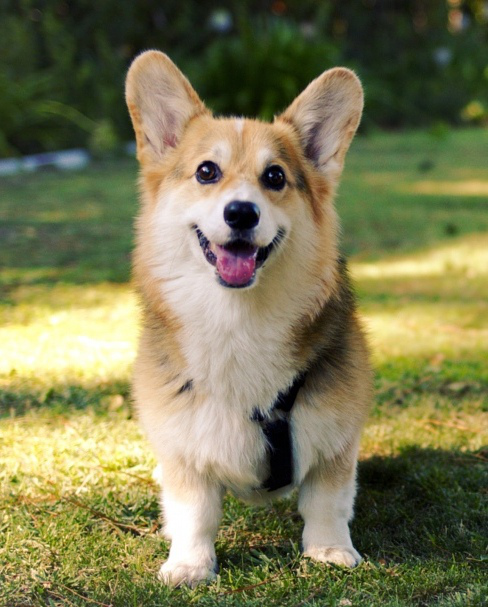

In [3]:
img

## Understanding image data structure

It can be a good habit to sample pixel values from the image to get a sense of the data structure and what it means. Not all picures use a 0 - 255 scale. Some go from 0 - 1. Since blurring is an averaging operation, I would expect similar numbers after performing my blur operation.

In [4]:
img = np.array(img)
print(img[335:338, 335:338])
print(img.shape)

[[[40 34 20]
  [35 31 22]
  [32 28 19]]

 [[41 38 19]
  [38 34 22]
  [33 29 17]]

 [[45 42 25]
  [48 46 33]
  [55 51 39]]]
(607, 488, 3)


## Making a kernel

The below function makes a [Gaussian Blur](https://en.wikipedia.org/wiki/Gaussian_blur) Kernel based on the following formula:

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/6717136818f2166eba2db0cfc915d732add9c64f" />

We are now going to construct a 3x5 kernel matrix, which we will use to implement our blurring function by convolving the original image with it.
First a vector of X coordinates is created like this:

In [5]:
width = 3
x_coordinates = [-width/2.0 + x +.5 for x in range(width)]
print(x_coordinates)

[-1.0, 0.0, 1.0]


Similarly, the same thing is done for the Y coordinates

In [6]:
height = 5
y_coordinates = [-height/2.0 + y +.5 for y in range(height)]
print(y_coordinates)

[-2.0, -1.0, 0.0, 1.0, 2.0]


Then, we can iterate through each combination of coordinates and plug them into the formula. At the end, each cell value is divided by the total of all the cell values to ensure the sum of the kernel is equal to 1.

In [7]:
def make_kernel(width=3, height=5, sigma=1.0):
    x_coordinates = [-width/2.0 + x +.5 for x in range(width)]
    y_coordinates = [-height/2.0 + y +.5 for y in range(height)]
    
    total = 0
    kernel = [[0 for cell in range(width)] for row in range(height)]
    for i in range(width):
        for j in range(height):
            x = x_coordinates[i]
            y = y_coordinates[j]
            cell_value = math.exp(-1*(x**2+y**2)/(2*sigma**2))
            total += cell_value;
            kernel[j][i] = cell_value;
    kernel = [[cell/total for cell in row] for row in kernel]
    return np.array(kernel)


make_kernel()

array([[0.01493364, 0.02462141, 0.01493364],
       [0.06692792, 0.11034549, 0.06692792],
       [0.11034549, 0.18192896, 0.11034549],
       [0.06692792, 0.11034549, 0.06692792],
       [0.01493364, 0.02462141, 0.01493364]])

## The simplest approach

Here is a straightforward way of applying the convolution. In human words, we inspect each row of the image, each column within that row, and each color within that column. Then for each row of the kernel, and each column of that row, we multiply that respective kernel cell value with the inspected image cell value.

A mouthful for sure, but an easier way think of it is we're multiplying each image cell value with each kernel cell value and adding together values that mapped back to the same image cell coordinates.

This process is called [convolution](https://en.wikipedia.org/wiki/Convolution#Notation) and is denoted as f ✶ g, or in our case img ✶ kernel

Warning the below takes a long time to run! We'll optimize it more.

In [8]:
t = time.time()


def blur_image_slow(image, kernel_width=7, kernel_height=7, sigma=3):
    kernel = make_kernel(width=kernel_width, height=kernel_height, sigma=sigma)

    # Set up the resulting image
    image_result_width = image.shape[1] - kernel_width + 1
    image_result_height = image.shape[0] - kernel_height + 1

    result_image = np.zeros(
        (image_result_height, image_result_width, image.shape[2]), dtype=np.uint8)

    # Apply the convolution
    for result_x in range(image_result_width):
        for result_y in range(image_result_height):
            for channel in range(image.shape[2]):
                # apply the kernel
                for kernel_x in range(kernel_width):
                    for kernel_y in range(kernel_height):
                        image_x = result_x + kernel_x
                        image_y = result_y + kernel_y
                        result_image[result_y][result_x][channel] += (
                            img[image_y][image_x][channel] * kernel[kernel_y][kernel_x])
    return result_image


dark_blurred_corgi = blur_image_slow(img)
print("Time taken: {} seconds".format(time.time() - t))

Time taken: 262.8857409954071 seconds


Ok, we have a blurry corgi!

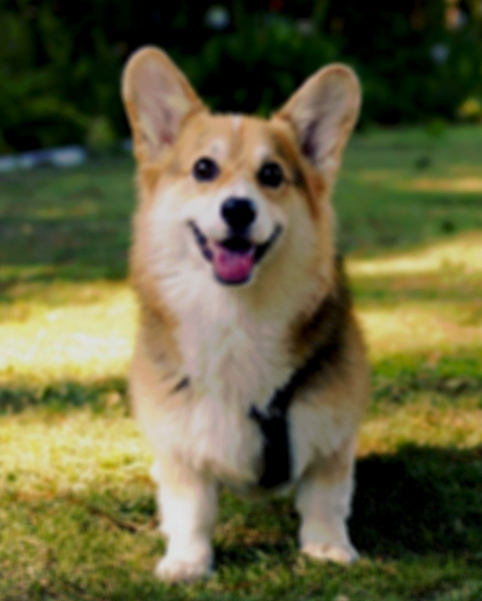

In [9]:
display_img = Image.fromarray(dark_blurred_corgi, 'RGB')
display_img

But wait, isn't it a little dark? And why did it take so long? Let's take a look at the pixel values.

In [10]:
dark_blurred_corgi[335:338, 335:338]

array([[[18, 15,  1],
        [19, 12,  2],
        [21, 17,  1]],

       [[19, 14,  2],
        [22, 13,  0],
        [23, 14,  2]],

       [[16, 10,  0],
        [18, 11,  2],
        [22, 16,  2]]], dtype=uint8)

The average of these is below that of our original image. What happened?
Since the data type is int, and the convolution used a float kernel, each operation rounds down the value that's being added to the blurred image result. (0,0,0) is black in images, and (255, 255, 255) is white, so that's why the image appears a little darker.

## Optimizing with NumPy

We can speed up the calculation and fix this problem using NumPy. There are a [number of tricks](https://hal.inria.fr/inria-00564007/document) to optimize NumPy to its fullest potential. The below uses broadcasting and takes advantage of np.sum, but it's a challenge to you to optimize it even further!

In [13]:
t = time.time()


def blur_image_fast(image, kernel_width=7, kernel_height=7, sigma=3):
    kernel = make_kernel(width=kernel_width, height=kernel_height, sigma=sigma)

    # Set up the resulting image
    image_result_width = image.shape[1] - kernel_width + 1
    image_result_height = image.shape[0] - kernel_height + 1

    def get_result_pixel(x, y):
        return np.sum(
            kernel[:,:,np.newaxis] *
            image[y:(y+kernel_height), x:(x+kernel_width)],
            axis=(0,1)
        )

    # Apply the convolution
    result_image = [[
        get_result_pixel(result_x, result_y)
         for result_x in range(image_result_width)]
        for result_y in range(image_result_height)]
    return np.asarray(result_image, dtype=np.uint8)


bright_blurred_corgi = blur_image_fast(img)
print(time.time() - t)

3.0794522762298584


Voila! A bright blurry corgi in a matter of seconds!

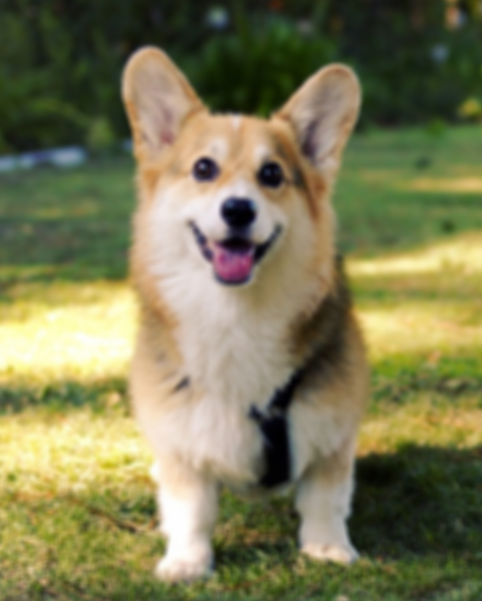

In [14]:
display_img = Image.fromarray(bright_blurred_corgi, 'RGB')
display_img